In [1]:
import xarray as xr
from pathlib import Path
import seaborn as sns
from sklearn import preprocessing
from sklearn.base import ClassifierMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn import linear_model, svm, metrics, multiclass, decomposition
from sklearn.neural_network import MLPClassifier

import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier, Booster

import matplotlib.pyplot as plt
from yellowbrick.classifier import class_prediction_error, classification_report, confusion_matrix, roc_auc

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train_ds = xr.open_dataset('train_set.nc', engine='h5netcdf')

In [3]:
yvar = 'cloud_type'
calipso_mask = train_ds[yvar].values

(array([   571.,   4827.,   9685.,   4995.,  26931.,  25763.,  64965.,
         39949., 163673.]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <a list of 9 Patch objects>)

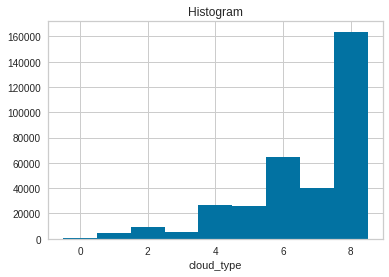

In [4]:
train_ds.cloud_type.plot.hist(bins=9, range=(0,9), align='left')

In [5]:
[(i, fm) for i, fm in enumerate(train_ds.cloud_type.flag_meanings)]

[(0, 'low overcast, transparent'),
 (1, 'low overcast, opaque'),
 (2, 'transition, stratocumulus'),
 (3, 'low, broken cumulus'),
 (4, 'altocumulus (transparent)'),
 (5, 'altostratus (opaque)'),
 (6, 'cirrus (transparent)'),
 (7, 'deep convective (opaque)'),
 (8, 'no cloud')]

In [6]:
def classify(arr, only=None):
    # 0 = no, 1 = low, 2 = mid, 3 = high, 4 = deep, 
    narr = np.zeros(arr.shape, dtype=int)
    narr[arr == 8] = 0
    narr[arr < 4] = 1
    narr[(arr == 4) | (arr == 5)] = 2
    narr[arr == 6] = 3
    narr[arr == 7] = 4
    if only is not None:
        out = np.zeros(narr.shape, dtype=int)
        out[narr == only] = 1
        return out
    else:
        return narr

In [7]:
vars_ = [v for v in train_ds.variables.keys() if 'CMI_C' in v] 
%time df = train_ds[vars_].isel(near=0).to_dataframe()
df = df.drop(columns=[c for c in df.columns if c not in vars_])

CPU times: user 633 ms, sys: 23.9 ms, total: 656 ms
Wall time: 656 ms


In [8]:
X = df.dropna(axis=0, how='any')
only = None
yo = calipso_mask[X.index].astype(int)
y = classify(yo, only)

In [9]:
drop = yo == 8
X = X[~drop]
y = y[~drop] 
X.shape, y.shape, y[y==1].shape

((177638, 16), (177638,), (20078,))

In [10]:
zero_len = len(y[y==0]) 
one_copies = zero_len // len(y[y==1])
one_inds = np.where(y==1)[0]
zero_inds = np.where(y == 0)[0]
#rz = np.random.choice(zero_inds, len(y[y==1]))
#all_inds = np.append(one_inds, rz)
if False:
    X = X.values[all_inds]
    y = y[all_inds]
else:
    X = X.values
X.shape, y.shape

((177638, 16), (177638,))

In [11]:
val_ds = xr.open_dataset('validate_set.nc', engine='h5netcdf')
#limit = (val_ds.cloud_type == 8) | (val_ds.cloud_type == 3)
val_df = val_ds.sel(near=0)[vars_].to_dataframe()#[limit.data]

val_df = val_df.drop(columns=[c for c in val_df.columns if c not in vars_])
val_nans = val_df.isna().any(axis=1)
X_val = val_df.dropna(axis=0, how='any')
yvo = val_ds[yvar].values[X_val.index].astype(int)
y_val = classify(yvo, only)

#cmask_val = mask_model.predict_proba(X_val.iloc[:, :-2])
#cmas_val = np.ones(y_val.shape)
#X_val.loc[:, 'cloud_mask'] = pd.Series(cmask_val[:, 0], index=X_val.index)
drop = yvo == 8
X_val = X_val.loc[~drop, df.columns]
y_val = y_val[~drop] 
X_val.shape, y_val.shape, y_val[y_val==1].shape

((40137, 16), (40137,), (4100,))

In [12]:
clf = MLPClassifier(solver='adam', activation='relu', alpha=1e-4, hidden_layer_sizes=(30,), max_iter=500, 
                    verbose=False, beta_1=0.8, beta_2=0.9, tol=1e-5)

model = Pipeline([
    ('scale', preprocessing.RobustScaler()),
    ('pca', decomposition.PCA(whiten=True)),
    ('multi', multiclass.OneVsRestClassifier(clf, n_jobs=-1))    
])
%time model.fit(X, y)

CPU times: user 312 ms, sys: 269 ms, total: 581 ms
Wall time: 1min 9s


Pipeline(memory=None,
         steps=[('scale',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=True)),
                ('multi',
                 OneVsRestClassifier(estimator=MLPClassifier(activation='relu',
                                                             alpha=0.0001,
                                                             batch_size='auto',
                                                             be...
                                                             beta_2=0.9,
                                                             early_stopping=False,
                                                             epsilon=1e-08,
                                                

In [13]:
model.score(X, y), model.score(X_val, y_val)

(0.8115437012350961, 0.8132396541844183)

/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


CPU times: user 907 ms, sys: 777 ms, total: 1.68 s
Wall time: 232 ms


/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0b9fd6358>,
                     classes=None,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7fd0b9f872b0>,
                     encoder=None, force_model=False, is_fitted='auto',
                     model=None, support=None)

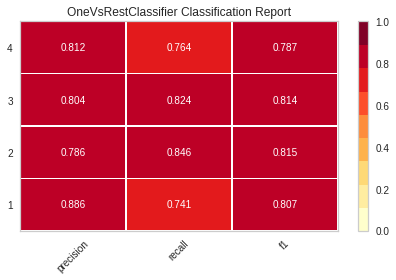

In [14]:
%matplotlib inline
%time classification_report(model, X, y)

CPU times: user 423 ms, sys: 344 ms, total: 767 ms
Wall time: 118 ms


/home/alorenzo/.pyenv/versions/miniconda3/envs/goesalg/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


ClassificationReport(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0b9f1f080>,
                     classes=None,
                     cmap=<matplotlib.colors.ListedColormap object at 0x7fd0b9ee54a8>,
                     encoder=None, force_model=False, is_fitted='auto',
                     model=None, support=None)

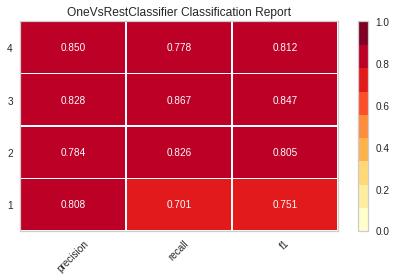

In [15]:
%matplotlib inline
%time classification_report(model, X_val, y_val)

In [16]:
%%time
ypred = model.predict(X)
ypred_val = model.predict(X_val)

CPU times: user 1.26 s, sys: 1.06 s, total: 2.32 s
Wall time: 322 ms


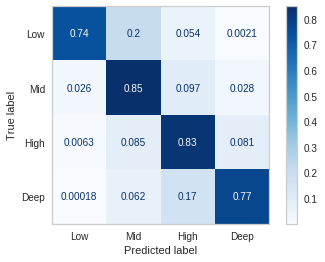

In [17]:
disp = metrics.plot_confusion_matrix(model, X, y,
                                     display_labels=['Low', 'Mid', 'High', 'Deep'],
                                     cmap=plt.cm.Blues,
                                     normalize='true')
disp.ax_.grid(False)

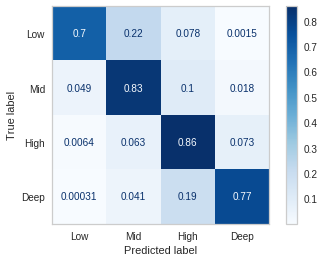

In [18]:
disp = metrics.plot_confusion_matrix(model, X_val, y_val,
                                     display_labels=['Low', 'Mid', 'High', 'Deep'],
                                     cmap=plt.cm.Blues,
                                     normalize='true')
disp.ax_.grid(False)

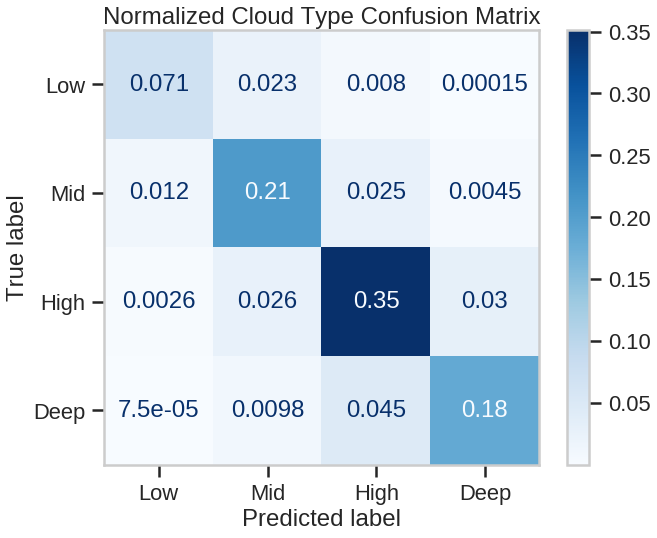

In [21]:
import seaborn as sns
with sns.plotting_context('poster'):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    metrics.plot_confusion_matrix(model, X_val, y_val,
                          display_labels=['Low', 'Mid', 'High', 'Deep'],
                          cmap=plt.cm.Blues,
                          normalize='all',
                          ax=ax)
    ax.grid(False)
    ax.set_title('Normalized Cloud Type Confusion Matrix')
    fig.savefig('cloud_type_confusion.png', dpi=300)

In [19]:
import pickle
with open('cloud_type.pkl', 'wb') as f:
    pickle.dump(model, f)